In [5]:
"""
Try to visualise what is going on with adverserial examples in 2d. Using tf is 
overkill for this but it lets me reuse my code easily
"""
%matplotlib notebook
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model, save_model
from keras import backend as K
import itertools as itr
from cleverhans.attacks_tf import fgm
import os
import argparse

sys.path.append('..')
from src.utilities import *

This notebook is to try to visualise what is going on with the BALD and entropy of models on adverserial examples, hopefully to gain some intuition into what is going on, on a 2D toy dataset.

Note that in high dimensions, these blobs may not be a very faithful representation of the distribution of datapoints. In particular, there is the well known result that most of the volume of a high dimensional volume is concentrated in a thin shell near the surface; to see this, recall that a the n-ball of radius r

$$
\mathcal{B}^n = \{ x \in \mathbb{R}^n : \| x \|_2 \leq r \}
$$

has a volume $$V_{ball} =K(n) r^n$$ where $$K(n)$$ is a constant that depends on the dimensionality only. Now, consider the fraction of the volume of the sphere that is inside the shell close to the boundary

$$
\mathcal{S}^n = \{ x \in \mathbb{R}^n : c r \lt \| x \|_2 \leq r \} \; \text{where} \; c \in [0,1]
$$

The volume of this shell is given simply by
$$
V_{shell} = K(n) ( r^n - (c r)^n)
$$

and so the fraction of the volume of the ball that is in the shell is

$$
\frac{V_{shell}}{V_{ball}} = \frac{ r^n - (c r)^n} {r^n} = 1 - c^n
$$

That is, as 

$$n \to \infty,\;\frac{V_{shell}}{V_{ball}} \to 1$$

For example, in 1000 dimensional space, the fraction of the sphere that is within 0.01 r from the surface of the sphere is 0.999957. The relevance to adverserial examples is that, for any fixed partitioning of the feature space into decision cells, the majority of points are in some sense close to a boundary, so the two dimensional view we see below where most points are well within the interior of decision regions may be misleading

<IPython.core.display.Javascript object>


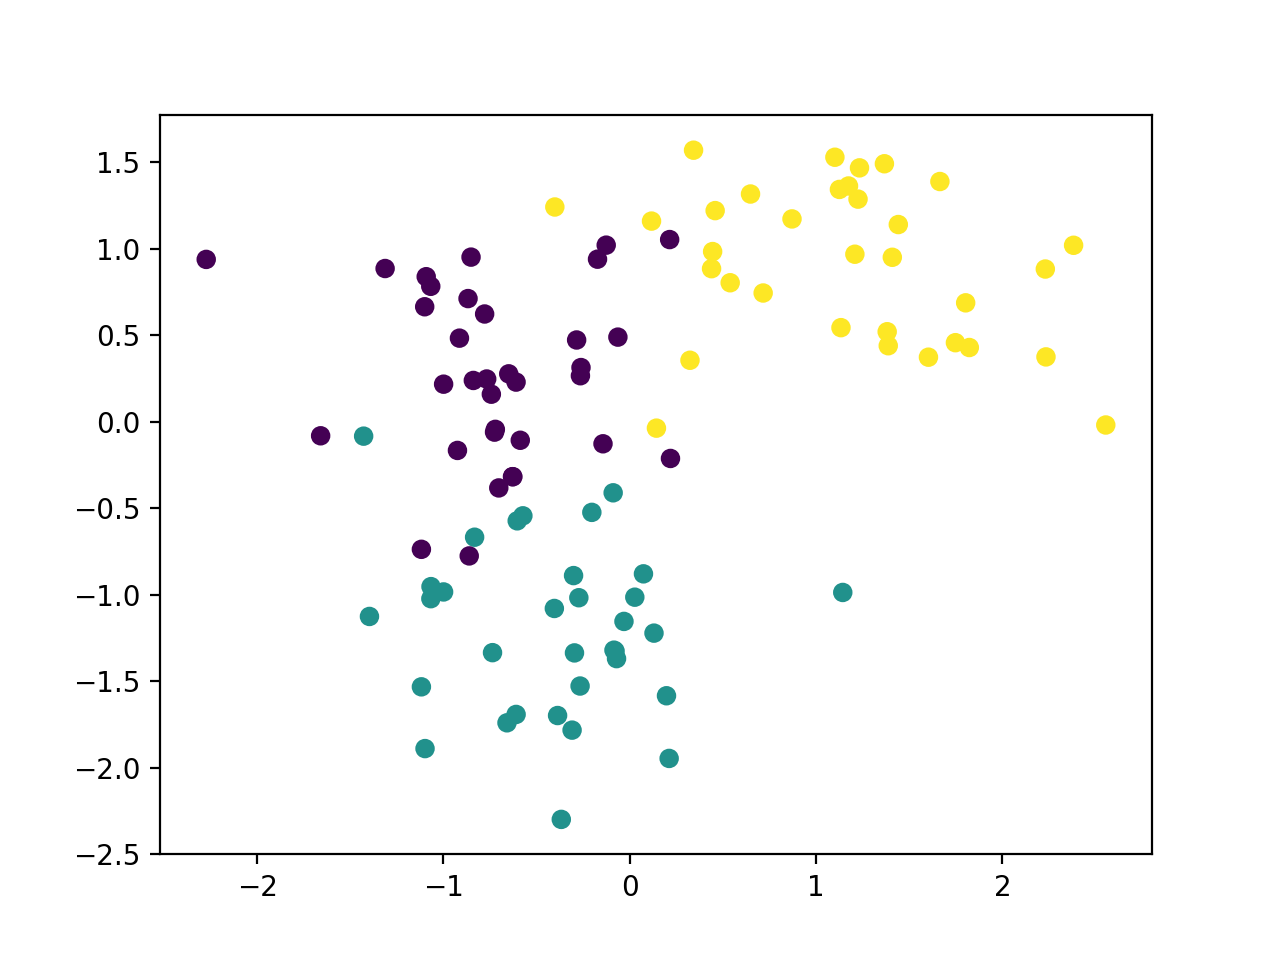

In [11]:
from sklearn.datasets import make_blobs
data,labels = make_blobs(n_features=2)
data -= data.mean(axis=0)
data /= data.std(axis=0)
plt.figure()
plt.scatter(data[:,0], data[:,1], c=labels)

In [7]:
inputs = keras.layers.Input(shape=(2,))
h1 = keras.layers.Dense(100, activation='relu')(inputs)
h2 = keras.layers.Dense(100, activation='relu')(h1)
predictions = keras.layers.Dense(3, activation='softmax')(h2)
model = keras.models.Model(input=inputs, outputs=predictions)

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

x = data
y = keras.utils.to_categorical(labels)
model.fit(x,y, epochs=20)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """


Epoch 1/20
100/100 [==============================] - 0s - loss: 1.0702 - acc: 0.4000     
Epoch 2/20
100/100 [==============================] - 0s - loss: 0.9372 - acc: 0.7900     
Epoch 3/20
100/100 [==============================] - 0s - loss: 0.8269 - acc: 0.8200     
Epoch 4/20
100/100 [==============================] - 0s - loss: 0.7255 - acc: 0.8200     
Epoch 5/20
100/100 [==============================] - 0s - loss: 0.6412 - acc: 0.8400     
Epoch 6/20
100/100 [==============================] - 0s - loss: 0.5714 - acc: 0.8400     
Epoch 7/20
100/100 [==============================] - 0s - loss: 0.5083 - acc: 0.8500     
Epoch 8/20
100/100 [==============================] - 0s - loss: 0.4513 - acc: 0.8800     
Epoch 9/20
100/100 [==============================] - 0s - loss: 0.4018 - acc: 0.9100     
Epoch 10/20
100/100 [==============================] - 0s - loss: 0.3592 - acc: 0.9400     
Epoch 11/20
100/100 [==============================] - 0s - loss: 0.3273 - acc: 0.9700   

<IPython.core.display.Javascript object>


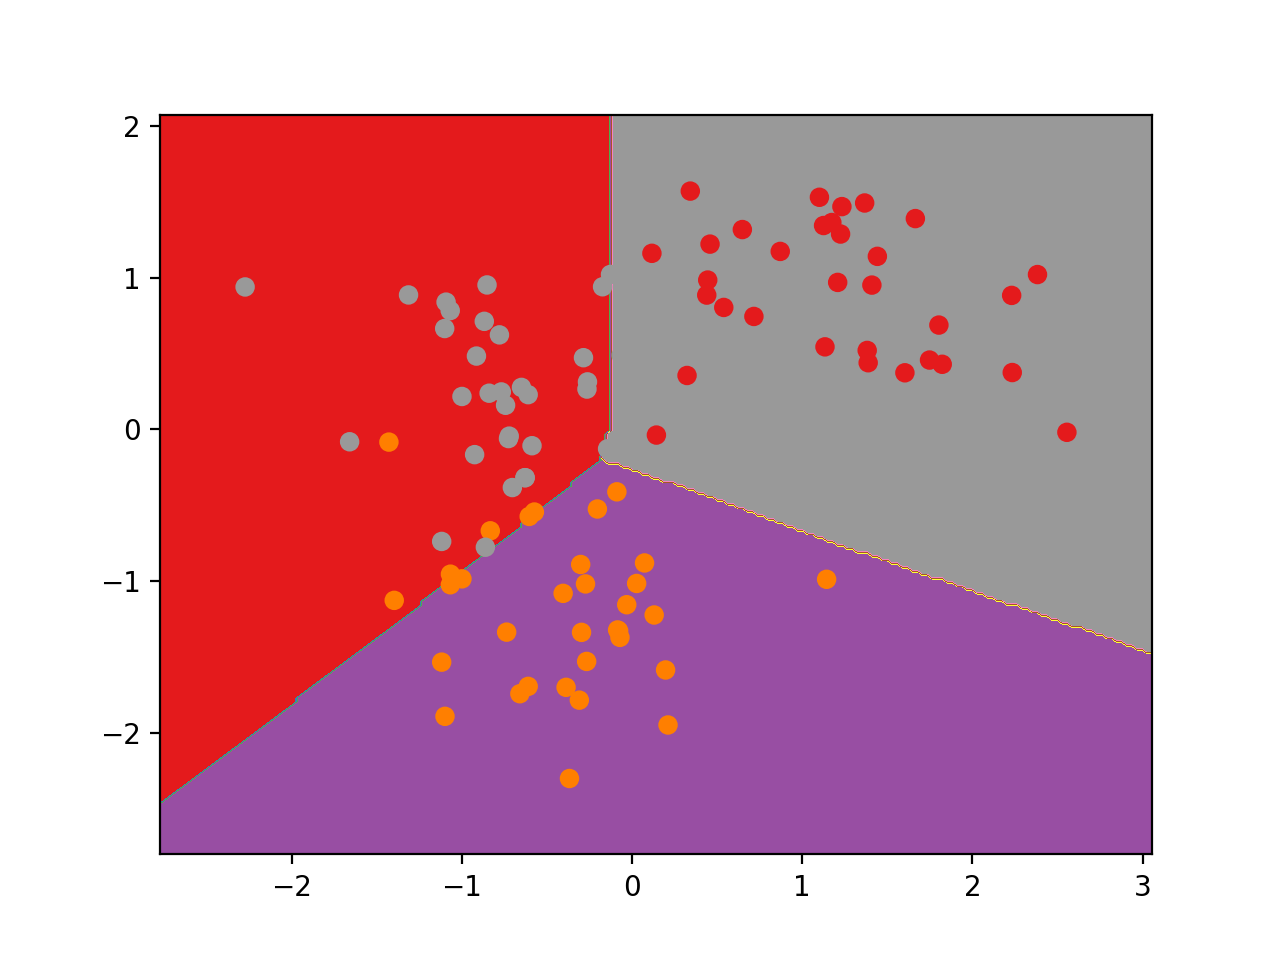

In [23]:
xx,yy = np.meshgrid(np.linspace(data[:,0].min() -.5,data[:,0].max() + .5, 200),
                    np.linspace(data[:,1].min()-.5,data[:,1].max()+.5, 200))

plot_x = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)
plot_preds = model.predict(plot_x)
plot_decision_bounds = np.argmax(plot_preds, axis=1).reshape(xx.shape)

plt.figure()
plt.contourf(xx,yy,plot_decision_bounds, cmap=plt.cm.Set1)
plt.scatter(data[:,0],data[:,1], c=labels, cmap=plt.cm.Set1_r); plt.show()

<IPython.core.display.Javascript object>


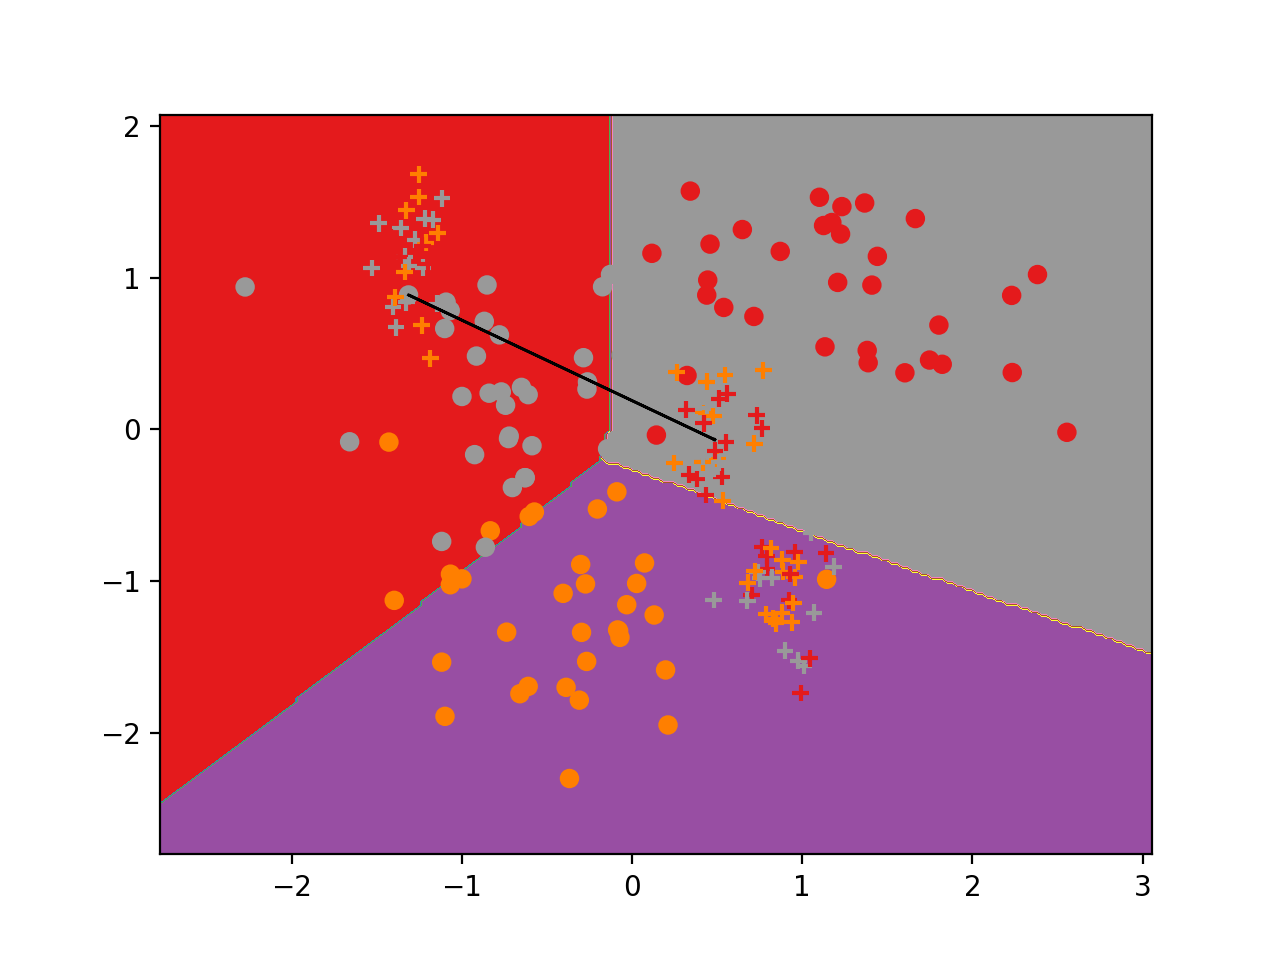

In [61]:
adv = fgm(inputs, predictions, eps = 0.1, ord = 1)
adv_points = adv.eval(session=K.get_session(),feed_dict={inputs: x})
plt.figure()
plt.contourf(xx,yy,plot_decision_bounds, cmap=plt.cm.Set1)
plt.scatter(data[:,0],data[:,1], c=labels , cmap=plt.cm.Set1_r); plt.show()
plt.scatter(adv_points[:,0], adv_points[:,1], c=labels, marker='+',cmap=plt.cm.Set1_r); plt.show()
plt.arrow(data[2,0],data[2,1],adv_points[2,0] - data[2,0], adv_points[2,1] - data[2,1])